In [9]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [10]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [11]:
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [12]:
# Train PINNs 

model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-4)

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


/tmp/ipykernel_3501528/1050756099.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [13]:
loss_track = []
pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(1000)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        loss_ic_1 = torch.mean((pred_left[:,0] - torch.sin(pi*x_left[:,0]) - 0.5 * torch.sin(3*pi*x_left[:,0])) ** 2)
        loss_ic_2 = torch.mean((ui_t)**2)

        loss_ic = loss_ic_1 + loss_ic_2

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])

        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)


100%|██████████| 1000/1000 [09:57<00:00,  1.67it/s]


In [14]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000357, Loss_BC: 0.004034, Loss_IC: 0.014876
Train Loss: 0.019268


relative L1 error: 0.326268
relative L2 error: 0.334919


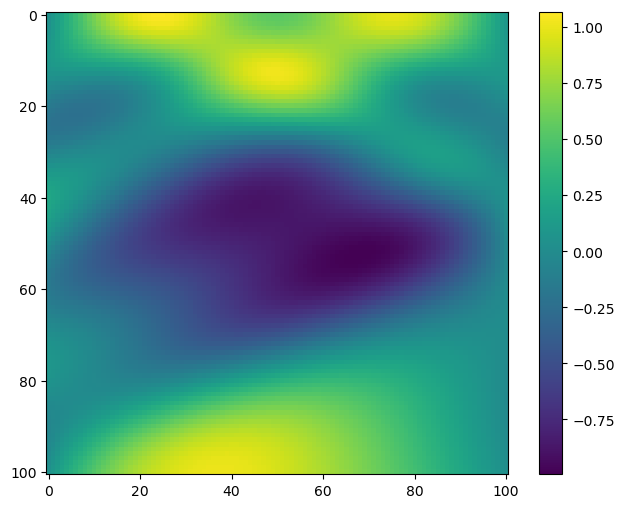

In [15]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def u_ana(x,t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(3*np.pi*x) * np.cos(6*np.pi*t)

res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(8,6))
plt.imshow(pred)
plt.colorbar()
plt.show()